<a href="https://colab.research.google.com/github/justcme/PerformanceSpecs/blob/main/6ImprovementIteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

###Directory

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Colab Notebooks/LipidPerf/from_Pandas')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###Imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

###Data

In [ ]:
df_base = pd.read_csv('Base/df_base.csv')
df0 = pd.read_csv('Base/df0.csv')

# FUNCTIONS

## 1. Calculate and create columns for variable PCE terms and sum them

In [ ]:
def AddSum2(df, par):
  newdf = df.copy()

  if par == 'TC':
    HDL = df.loc[:,'HDL']
    TC = df.iloc[:,12]
  elif par == 'HDL':
    HDL = df.iloc[:,12]
    TC = df.loc[:,'TC']
  else:
    HDL = df.loc[:,'HDL']
    TC = df.loc[:,'TC']

  vcoeffs = ['CTotalChol','CAgeTotalChol','CHDLChol','CAgeHDLChol']

  var_list = [np.log(TC), np.log(age)*np.log(TC), np.log(HDL), np.log(age)*np.log(HDL)]

  newdf.loc[:,'add_sum']=0

  for t,k in zip(vcoeffs, var_list):
    newdf.loc[:,'add_sum'] += df[t]*k
  
  return newdf

## 2. Pooled Cohort Equation (PCE)

In [ ]:
def PCEcalc2(df):
  newdf = df.copy()

  newdf['terms'] = df['interum_sum'] + df['add_sum']
  newdf['PCE'] = 100*(1 - newdf['S10'] ** (np.e ** (newdf['terms'] - newdf['MeanTerms'])))
  
  return newdf

## 3. Calculate LDL-C

In [ ]:
def BLipoType2(df, par, Btype):
  """This function calculates LDL-C using the Friedewald equation, non-HDL-C,
  and the ASCVD risk using the pooled cohort equation (PCE) from the American Heart Association."""

  newdf = df.copy()

  if par == 'TC':
    HDL = newdf.loc[:,'HDL']
    TG = newdf.loc[:,'TG']
    TC = newdf.iloc[:,12]
  elif par == 'HDL':
    HDL = newdf.iloc[:,12]
    TG = newdf.loc[:,'TG']
    TC = newdf.loc[:,'TC']
  else:
    HDL = newdf.loc[:,'HDL']
    TG = newdf.iloc[:,12]
    TC = newdf.loc[:,'TC']

  if Btype == 'LDL':
    # To calculate LDL-C: where TG<=400, use Friedewald, where >400, use Sampson  
    newdf.loc[:,'cLDL'] = np.select(condlist = [newdf.loc[:,'TG']<=400, newdf.loc[:,'TG']>400],
                                    choicelist = [TC - HDL - TG/5, TC/0.948 - HDL/0.971 - (TG/8.56 + (TG*(TC - HDL))/2140 - (TG**2)/16100) - 9.44],
                                    default = np.nan)      
  else:
    newdf['NHDL'] = TC - HDL

  return newdf

## 4. Risk Group Determination

In [ ]:
def Groups2(df,par, BType):
  """This function determines the Risk Group (A-D) based on LDL-C and non-HDL-C and creates a column for each."""

  newdf = df.copy()

  if par == 'TG':
    TG = newdf.iloc[:,12]
  else:
    TG = newdf.loc[:,'TG']

  PCE = newdf['PCE']

  if BType == 'LDL':
    LDL = newdf['cLDL']
    newdf.loc[:,'Lgroup'] = np.nan
    newdf.loc[:,'Lgroup'] = np.select(condlist=[(PCE<7.5) | (LDL<70),
                                                (PCE >=20) | (LDL >=190),
                                                (LDL >=70) & (LDL <160) & (TG <175),
                                                (LDL >=160) | (TG >=175)],
                                      choicelist=['A','D', 'B', 'C'],
                                      default=np.nan)
  else:
    NHDL = newdf['NHDL']
    newdf.loc[:,'Ngroup'] = np.nan
    newdf.loc[:,'Ngroup'] = np.select(condlist=[(PCE<7.5) | (NHDL<90),
                                                (PCE >=20) | (NHDL >=220),
                                                (NHDL >=90) & (NHDL <190) & (TG <175),
                                                (NHDL >=190) | (TG >=175)],
                                      choicelist=['A','D', 'B', 'C'],
                                      default=np.nan)

  return newdf

##5. Call all functions to add necessary columns

In [ ]:
def AddCols2(df,par,BType):
  """This function adds variability to the lipid results and then calculates the terms for PCE calculation that are dependent on these.
    It then sums those terms."""

#Add Sum of variable terms
  df = AddSum2(df,par)
  df = PCEcalc2(df)
  df = BLipoType2(df,par,BType)
  df = Groups2(df,par,BType)

  return df

## 6. Iterated Bias

In [ ]:
def IterBias(BType, grouptype):
  IterB = np.arange(0.90,1.10,0.02, dtype = 'float')
  AveReclassdB = {}
  AveReclassdB['Bias (%)'] = (IterB*100 - 100).astype(int)
  for n,param in enumerate(params):
    AveReclassdB[param] = []

    for bias in IterB:
      iter_bias = iter_df.copy()
      total_reclassificationsB = 0
      ReClassListB = []

      iter_bias.loc[:,f'{param}_bias'] = bias*iter_bias.loc[:,param]

      #If new values <0, make them = 1
      iter_bias.loc[:,f'{param}_bias'] = np.select(condlist = [iter_bias.loc[:,f'{param}_bias']<0, iter_bias.loc[:,f'{param}_bias']>=0],
                                                   choicelist = [1,iter_bias.loc[:,f'{param}_bias']],
                                                   default = np.nan)
      
      iter_bias = AddCols2(iter_bias, param, BType)

      XTB = pd.DataFrame(pd.crosstab(iter_bias[grouptype], df0[grouptype], normalize = True))
      reclassTotalB = round(100*(1-XTB.loc['A','A']-XTB.loc['B','B']-XTB.loc['C','C']-XTB.loc['D','D']), ndigits=1)
      ReClassListB.append(reclassTotalB)

      AveReclassdB[param].append(round(mean(ReClassListB), ndigits=2))

  totalmeansB = pd.DataFrame(AveReclassdB)
  return totalmeansB
#  totalmeansB.to_csv(f'Iterations/BXTmeans_{param}')

## 7. Iterated Imprecision

In [ ]:
#np.random.randint(0,300,150)

In [ ]:
Seeds = [ 60,  12, 255, 197,  19,  49, 123,  33,  72, 272, 190, 172, 172,
       224, 282,  59,  29,  68,  95, 276, 184,   1, 158, 170, 171, 220,
       122, 223,  32, 113, 269, 257,  42, 282,  41,  79, 176,  36, 140,
       150, 137,  65, 265, 158, 164,  74,  40, 285, 115,  82,   8,  11,
        20, 172, 108, 166, 246, 254,  86,   7, 283, 182, 236, 202,  31,
        97, 256, 265, 146,  51,  88, 103, 156, 172,  35,  74,   9, 147,
        71,  21, 134, 207, 231, 236,  27, 233, 228,   9, 143, 117, 270,
        39, 217, 245, 237, 203, 296, 184, 138, 150, 192, 237, 158, 170,
       169, 215,  15, 145, 176, 124,  20, 205, 109, 179, 255, 219, 273,
       246,  46, 236, 127, 179,  66, 143,   4,  50, 212, 299, 204,  52,
       269, 134, 132, 182, 195, 243, 136, 195, 140,  84, 175,  38, 144,
       177, 124,  67, 104, 286, 137, 136]

In [ ]:
def IterImp(BType, grouptype):
  IterI = np.arange(1,9)/100
  AveReclassdI = {}
  AveReclassdI['Imprecision (%)'] = (IterI*100).astype(int)
  for n,param in enumerate(params):
    AveReclassdI[param] = []

    for imp in IterI:
      iter_imp = iter_df.copy()
      total_reclassificationsI = 0
      ReClassListI = []

      for m in range(50):
        pos = 3*m + n
        a = np.random.RandomState(Seeds[pos])
        iter_imp.loc[:,f'{param}_imp'] = norm.ppf(a.uniform(1e-16,0.9999999999999999,8506),
                                                  loc = iter_imp.loc[:,param], scale = imp*iter_imp.loc[:,param]).astype('int')

        iter_imp = AddCols2(iter_imp, param, BType)

        XTI = pd.DataFrame(pd.crosstab(iter_imp[grouptype], df0[grouptype], normalize = True))
        reclassTotalI = round(100*(1-XTI.loc['A','A']-XTI.loc['B','B']-XTI.loc['C','C']-XTI.loc['D','D']), ndigits=1)
        ReClassListI.append(reclassTotalI)

      AveReclassdI[param].append(round(mean(ReClassListI), ndigits=2))
  totalmeansI = pd.DataFrame(AveReclassdI)

  return totalmeansI
#totalmeansI.to_csv(f'Iterations/IXTmeans_{param}')

#DATA MANIPULATION

###Create Dataframes

In [ ]:
#base dataframe with variables for PCE calculation
iter_df = df_base.iloc[:,[0,1,37,38,48,9,10,11,26,27,28,29]]

Global Variables

In [ ]:
params=['TC','HDL','TG']
age = iter_df.loc[:,'age']

# CALL FUNCTIONS

In [ ]:
biasd_LDL = IterBias('LDL','Lgroup')
biasd_NHDL = IterBias('NHDL','Ngroup')

In [ ]:
imprecise_LDL = IterImp('LDL','Lgroup')
imprecise_NHDL = IterImp('NHDL','Ngroup')

# PLOT DATA

In [ ]:
biasd_LDL['BLip'] = 'cLDL-C'
biasd_NHDL['BLip'] = 'non-HDL-C'
biasd_plot_df = pd.concat([biasd_LDL, biasd_NHDL], ignore_index= True)
biasd_plot_df.head()

,Bias (%),TC,HDL,TG,BLip
0,-10,8.0,4.9,1.8,cLDL-C
1,-8,6.5,3.9,1.5,cLDL-C
2,-6,5.1,3.1,1.1,cLDL-C
3,-3,3.6,2.0,0.7,cLDL-C
4,-1,2.0,0.9,0.2,cLDL-C


In [ ]:
imprecise_LDL['BLip'] = 'cLDL-C'
imprecise_NHDL['BLip'] = 'non-HDL-C'
imprecise_plot_df = pd.concat([imprecise_LDL, imprecise_NHDL], ignore_index= True)
imprecise_plot_df.head()

,Imprecision (%),TC,HDL,TG,BLip
0,1,0.95,0.60,0.10,cLDL-C
1,2,1.77,0.87,0.26,cLDL-C
2,3,2.51,1.23,0.42,cLDL-C
3,4,3.25,1.57,0.59,cLDL-C
4,5,3.93,1.91,0.75,cLDL-C


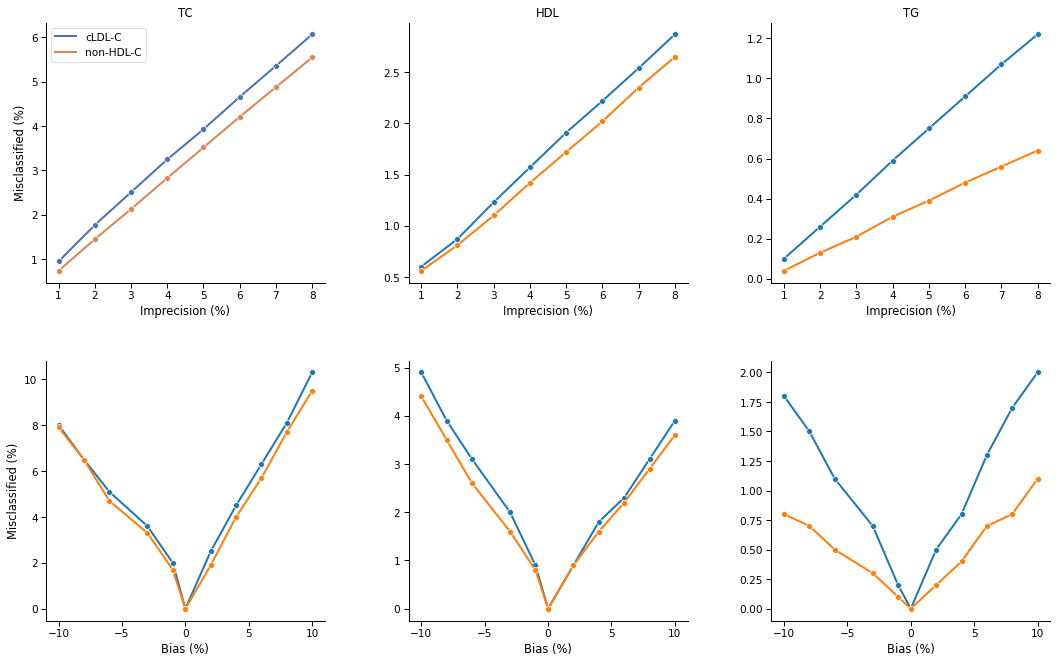

In [ ]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows = 2, ncols = 3, sharex='row', figsize=(18,11), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
#fig.suptitle('Effect of imprecision and bias in each parameter on reclassification by LDL-C and nonHDL-C', y= 0.98, fontsize=15)

sns.set_context('paper', font_scale=1.2, rc={"lines.linewidth": 2, "lines.markersize":6})

#Imprecision on LDL and NHDL
sns.lineplot(data = imprecise_plot_df, x='Imprecision (%)', y='TC', ax=ax1, palette='deep', marker = 'o', hue = 'BLip')
sns.lineplot(data = imprecise_plot_df, x='Imprecision (%)', y='HDL', ax=ax2, marker = 'o', hue = 'BLip', legend = False)
sns.lineplot(data = imprecise_plot_df, x='Imprecision (%)', y='TG', ax=ax3, marker = 'o', hue = 'BLip', legend = False)

## Bias on LDL and NHDL
sns.lineplot(data = biasd_plot_df, x='Bias (%)', y='TC', ax=ax4, marker = 'o', hue = 'BLip', legend = False)
sns.lineplot(data = biasd_plot_df, x='Bias (%)', y='HDL', ax=ax5, marker = 'o', hue = 'BLip', legend = False)
sns.lineplot(data = biasd_plot_df, x='Bias (%)', y='TG', ax=ax6, marker = 'o', hue = 'BLip', legend = False)

sns.despine()
ax1.legend(title=None)
for ax,p in zip([ax1,ax2,ax3],params):
  ax.set_title(p)
for ax in (ax1,ax4):
  ax.set_ylabel('Misclassified (%)')
for ax in (ax2,ax3,ax5,ax6):
  ax.set_ylabel('')

fig.savefig('Figures/PNG/Iterations.png', dpi = 600)

In [ ]:
fig.savefig('Figures/Iterations.jpg', dpi = 600)